Number of points in the dataset =  709


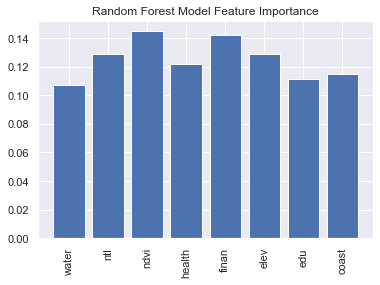

Explained variation per principal component: [0.45224168 0.22687826 0.08474925]
Accuracy of Model =  0.6666666666666666


In [17]:
# Import Packages

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Import Data

data = pd.read_csv(r"C:\Users\martin.szigeti\Documents\UN Work\social vulnerability index/SV_Raster_training.csv")  # taken as clean
data['LATNUM'] = data['LATNUM'].astype(float)
pd.set_option("display.max_columns", None)
data = data.drop('geometry', axis=1)  # drop geometry // unsure how to use data
data = data.drop('Unnamed: 0', axis=1)  # already indexed
data = data.drop('DHSCLUST', axis=1)  # cluster (interview) label
data = data.dropna()

'''
Task: Predict which bucket (SV Score range) new data (group) should fit into
Purpose: Following calculation of SV for new group, this model would run in the background to check the score fits into 
the predicted bucket.
Justification: Statement about how for certain groups incorrect scores (with significant error)
have been calculated using current tool. 


'''


def knn_classification(df):
    """

    Bucket target variable into bins, define and scale Features

    """

    print("Number of points in the dataset = ", len(df))

    # Buckets work as follows:
    # SV score X such that -20 < X < -15 has Label = -20
    df['target_bin'] = pd.cut(df['SV'], [-20, -15, -10, -5, 0, 5, 10, 15, 20], labels=['-20', '-15', '-10', '-5', '0',
                                                                                       '5', '10', '15'])
    # Define Features
    # 'road', (Feature removed)
    features = ['water', 'ntl', 'ndvi', 'health', 'finan', 'elev', 'edu', 'coast']

    # Scale Features between 0-1
    df[features] = minmax_scale(df[features])

    """

    Feature Importance using Random Forest Classifiers 
    STATUS: RUN --> Removal of Feature 'road'

    """

    X = df[features]
    y = df['target_bin']

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42)

    # Model and Feature Importance Results
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    feature_df = pd.DataFrame({"Importance": rf_model.feature_importances_,
                               "Features": features})
    sns.set()
    plt.bar(feature_df["Features"], feature_df["Importance"])
    plt.xticks(rotation=90)
    plt.title("Random Forest Model Feature Importance")
    plt.show()

    """

    PCA Reduction

    """

    x1 = df[features].values

    pca_svcc = PCA(n_components=3)  # svcc "Social Vulnerability Calculation Check"
    principalComponents_svcc = pca_svcc.fit_transform(x1)

    pca_Df = pd.DataFrame(data=principalComponents_svcc
                          , columns=['principal component 1', 'principal component 2', 'principal component 3'])

    print('Explained variation per principal component: {}'.format(pca_svcc.explained_variance_ratio_))

    """

    Prediction Model

    """

    x = pca_Df[['principal component 1', 'principal component 2', 'principal component 3']]

    # Split into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.02, random_state=42)

    knn = KNeighborsClassifier(n_neighbors=6, weights='distance', algorithm='auto', leaf_size=15, p=2,
                               metric='minkowski', metric_params=None, n_jobs=None)

    knn.fit(x_train, y_train)

    # Predict on dataset which model has not seen before
    prediction = knn.predict(x_test)

    # Calculate the accuracy of the model
    prediction = pd.DataFrame(prediction, columns=['prediction'])
    y_test = y_test.reset_index()
    y_test = y_test.drop(['index'], axis=1)
    result = pd.concat([prediction, y_test], axis=1, ignore_index=False, names=['prediction', 'y_test'])
    result['accuracy'] = np.where(result['prediction'] != result['target_bin'], 0, 1)
    print("Accuracy of Model = ", result['accuracy'].sum() / len(result))

    return(knn)

#  RUN knn_classification

model = knn_classification(data)

In [11]:
data["target_bin"].unique()

['0', '-5', '5', '-10', '10', '15', '-15']
Categories (7, object): ['-15' < '-10' < '-5' < '0' < '5' < '10' < '15']

In [ ]:
data

In [18]:
model()

KNeighborsClassifier(leaf_size=15, n_neighbors=6, weights='distance')

In [23]:
import rasterio as rio

with rio.open(r"C:\Users\martin.szigeti\Documents\UN Work\social vulnerability index\Notebooks\Data\Albania\merged/merged.tif") as src:
    raster = src.read()
#   raster = raster[:, 400:2900, 200:1500]
    rasterdf = pd.DataFrame(raster.reshape([9,-1]).T)
    rasterdf.columns = ["coast","ndvi","edu","elev","finan","health","ntl","road","water"]

In [26]:
from sklearn.preprocessing import MinMaxScaler
rasterdf_scaled = MinMaxScaler().fit_transform(rasterdf)
rasterdf_scaled = pd.DataFrame(rasterdf_scaled, index = rasterdf.index, columns = rasterdf.columns)
# rasterdf_scaled2 = StandardScaler().fit_transform(rasterdf)
# rasterdf_scaled2 = pd.DataFrame(rasterdf_scaled2, index = rasterdf.index, columns = rasterdf.columns)

In [ ]:
pred = model.predict()

In [29]:
features = ['water', 'ntl', 'ndvi', 'health', 'finan', 'elev', 'edu', 'coast']
x1 = rasterdf[features].values
pca_svcc = PCA(n_components=3)  # svcc "Social Vulnerability Calculation Check"
principalComponents_svcc = pca_svcc.fit_transform(x1)
pca_Df = pd.DataFrame(data=principalComponents_svcc
                      ,columns=['principal component 1', 'principal component 2', 'principal component 3'])
x = pca_Df[['principal component 1', 'principal component 2', 'principal component 3']]
prediction = model.predict(x)

In [33]:
prediction.shape

(5356020,)

In [37]:
def arraytoraster(outname,array):
    import os
    from osgeo import gdal
    # This is our reference file for metadata for good measure
    rast_src = gdal.Open(r"C:\Users\martin.szigeti\Documents\UN Work\social vulnerability index\Notebooks\Data\Albania\merged/merged.tif", 1) # 1 = read only
    driver = gdal.GetDriverByName('GTiff')
    if not os.path.exists('predictions'):
        os.makedirs('predictions')
    dataset = driver.Create("predictions/"+ outname, rast_src.RasterXSize, rast_src.RasterYSize, 1, gdal.GDT_Float32)
    print("X size merged: ",rast_src.RasterXSize)
    print("Y size merged: ",rast_src.RasterYSize)
    # we need to check if the values are in the correct format, some predictors spit out their prediction in some awkward format
    if isinstance(array,pd.Series):
        print("true")
        array = np.asarray(array).reshape(rast_src.RasterXSize,rast_src.RasterYSize)
    dataset.GetRasterBand(1).WriteArray(array.reshape(rast_src.RasterYSize,rast_src.RasterXSize))

    # follow code is adding GeoTranform and Projection
    geotrans=rast_src.GetGeoTransform()  #get GeoTranform from existed 'data0'
    proj=rast_src.GetProjection() #you can get from a exsited tif or import 
    dataset.SetGeoTransform(geotrans)
    dataset.SetProjection(proj)
    dataset.FlushCache()
    dataset=None

In [38]:
arraytoraster("lol.tif",prediction)

X size merged:  1780
Y size merged:  3009
